In [1]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-06-28 15:11:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   244MB/s    in 0.7s    

2022-06-28 15:11:28 (244 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
import os
for path, dirs, files in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirs)} directories and {len(files)} files in {path}")

There are 2 directories and 0 files in 10_food_classes_10_percent
There are 10 directories and 0 files in 10_food_classes_10_percent/test
There are 0 directories and 250 files in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 files in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 files in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 files in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 files in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 files in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 files in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 files in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 files in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 files in 10_food_classes_10_percent/test/ramen
There are 10 directories and 0 fil

In [3]:
from pathlib import Path
main_dir = Path("10_food_classes_10_percent/train")
class_names = sorted([item.name for item in main_dir.glob("*")])
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [4]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
IMAGE_SHAPE = (224, 224)

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.2,
                                   shear_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size= BATCH_SIZE,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size= BATCH_SIZE,
                                             class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub

In [6]:
# Function for tensorboard callback

import datetime
def create_tensorboard_callback(dirname, experiment_name):
  log_dir = dirname + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard logs to {log_dir}")
  return tensorboard_callback

In [22]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [8]:
# function to return modified model

def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extractor_layer",
                                           input_shape=IMAGE_SHAPE + (3,))
  model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes,
                          activation="softmax",
                          name="output_layers")
  ])
  
  return model

In [12]:
EPOCHS = 5
model_1 = create_model(resnet_url)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

history_1 = model_1.fit(train_data,
            epochs=EPOCHS, 
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=len(test_data),
            callbacks=[create_tensorboard_callback(dirname="tensorflow_hub",
                                                   experiment_name="resnet50v2")])

Saving TensorBoard logs to tensorflow_hub/resnet50v2/20220628-151726
Epoch 1/5
24/24 [==============================] - 35s 1s/step - loss: 2.0005 - accuracy: 0.3280 - val_loss: 1.2784 - val_accuracy: 0.5856
Epoch 2/5
24/24 [==============================] - 23s 960ms/step - loss: 1.0747 - accuracy: 0.6733 - val_loss: 0.9330 - val_accuracy: 0.6924
Epoch 3/5
24/24 [==============================] - 23s 970ms/step - loss: 0.8433 - accuracy: 0.7293 - val_loss: 0.7876 - val_accuracy: 0.7432
Epoch 4/5
24/24 [==============================] - 26s 1s/step - loss: 0.6772 - accuracy: 0.7973 - val_loss: 0.7342 - val_accuracy: 0.7608
Epoch 5/5
24/24 [==============================] - 23s 978ms/step - loss: 0.6008 - accuracy: 0.8200 - val_loss: 0.7077 - val_accuracy: 0.7632


In [13]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

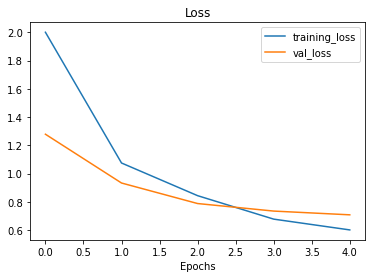

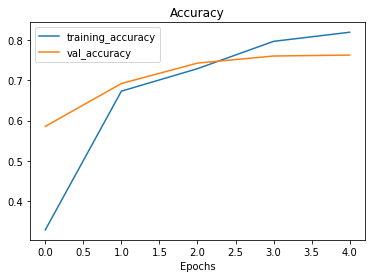

In [14]:
plot_loss_curves(history_1)

In [15]:
model_1.evaluate(test_data)

79/79 [==============================] - 13s 159ms/step - loss: 0.7077 - accuracy: 0.7632


[0.707684338092804, 0.7631999850273132]

In [16]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layers (Dense)       (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [23]:
EPOCHS = 5
model_2 = create_model(efficientnet_url)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

history_2 = model_2.fit(train_data,
                        epochs=EPOCHS,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback("tensorflow_hub", "EfficientNetB0")])

Saving TensorBoard logs to tensorflow_hub/EfficientNetB0/20220628-153306
Epoch 1/5
24/24 [==============================] - 32s 1s/step - loss: 1.9581 - accuracy: 0.3533 - val_loss: 1.4081 - val_accuracy: 0.6812
Epoch 2/5
24/24 [==============================] - 22s 954ms/step - loss: 1.2331 - accuracy: 0.7160 - val_loss: 0.9626 - val_accuracy: 0.7944
Epoch 3/5
24/24 [==============================] - 22s 948ms/step - loss: 0.9132 - accuracy: 0.7853 - val_loss: 0.7705 - val_accuracy: 0.8284
Epoch 4/5
24/24 [==============================] - 22s 941ms/step - loss: 0.7711 - accuracy: 0.8067 - val_loss: 0.6708 - val_accuracy: 0.8420
Epoch 5/5
24/24 [==============================] - 22s 947ms/step - loss: 0.6695 - accuracy: 0.8373 - val_loss: 0.6093 - val_accuracy: 0.8504


In [24]:
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layers (Dense)       (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [25]:
model_2.evaluate(test_data)

79/79 [==============================] - 12s 152ms/step - loss: 0.6093 - accuracy: 0.8504


[0.6092633605003357, 0.8503999710083008]

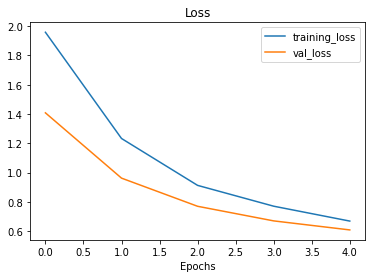

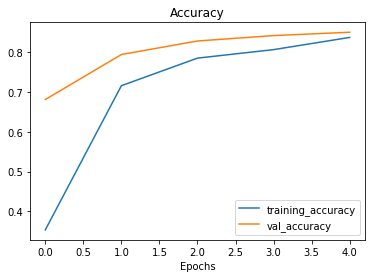

In [26]:
plot_loss_curves(history_2)